In [1]:
## This is a series of examples using the icanswim/cosmosis data science and machine learning repo

In [1]:
from model import FFNet, tv_model, ResBam
from learning import Learn, Selector, Metrics
from dataset import SKDS, TVDS, CDataset, ImageDatasetStats, AsTensor, Squeeze, DType

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [3]:
## Example of generic/custom dataset and transforms
import numpy as np

class DummyDataset(CDataset):

    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([.02]),
                       'feature_3': np.asarray(['c']),
                       'feature_4': np.asarray(['b','a']),
                       'feature_5': np.asarray([1.1])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([.01]),
                       'feature_3': np.asarray(['a','b','d']),
                       'feature_4': np.asarray(['d']),
                       'feature_5': np.asarray([1.2])}}
        
        print(boom)
        return datadic
    
class DummyTransform():
    def __call__(self, arr):
        return np.add(arr, 2)
    
class DummyTransformTwo():
    def __call__(self, arr):
        return np.multiply(arr, .1)
    
ds_params = {'train_params': {'features': ['feature_1','feature_5'],
                              'embeds': ['feature_3','feature_4'],
                              'targets': ['feature_2'],
                              'embed_lookup': {'a': 1, 'b': 2, 'c': 3, 'd': 4, '0': 0},
                              'transform': [DummyTransform(), DummyTransformTwo()],
                              'target_transform': [],
                              'pad': 4,
                              'do_not_pad': ['feature_1','feature_2','feature_3'],
                              'boom': 'bang'}}
    
d = DummyDataset(**ds_params['train_params'])
d[2]

bang
CDataset created...


(array([0.203, 0.32 , 0.2  , 0.2  , 0.2  ]),
 [array([1, 2, 4]), array([4, 0, 0, 0])],
 array([0.01]))

In [4]:
## Example of sklearn regression dataset wrapper
ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'make': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

CDataset created...
SKDS make_regression created...


(array([ 0.11740898, -1.5081471 , -0.19726104, -0.83461297,  0.46581295],
       dtype=float32),
 [],
 array([-132.78094], dtype=float32))

In [5]:
## Example of sklearn classification dataset wrapper
ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'make': 'make_classification',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 10,
                                            'n_informative': 8,
                                            'n_clusters_per_class': 2,
                                            'flip_y': 0.05,
                                            'class_sep': 0.01,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]

CDataset created...
SKDS make_classification created...


(array([ 2.938037  ,  0.8895144 ,  3.184168  ,  3.6238668 , -0.11906572,
        -0.69702244, -1.5829041 , -1.7054816 , -2.0266538 ,  0.46292216],
       dtype=float32),
 [],
 array([3]))

In [6]:
## Example of torchvision wrapper
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

CDataset created...
TVDS created...


(<PIL.Image.Image image mode=L size=224x224 at 0x7F5AAEA21EE0>, [], 0)

In [7]:
## Example of torchvision dataset wrapper with PIL transform
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

CDataset created...
TVDS created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


CDataset created...
SKDS make_regression created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:02.625415
epoch: 0, lr: 0.01
train loss: 595002.4791666666, val loss: 579609.6
sklearn train metric: 0, sklearn validation metric: 0
test loss: 12431.8322265625
learning time: 0:00:09.956162
sklearn test metric: 
0 



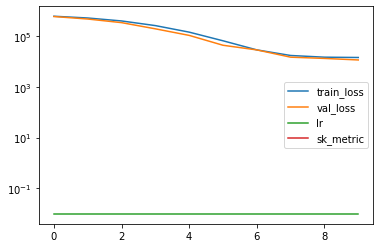

In [8]:
## Example sklearn regression dataset wrapper with custom model
model_params = {'D_in': 256, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': []}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'transform': [],
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=10)

CDataset created...
SKDS make_classification created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:00.999136
epoch: 0, lr: 0.01
train loss: 1.4224889565397192, val loss: 1.3973634134639392
sklearn train metric: 0.5064362562968382, sklearn validation metric: 0.49721198957793966
test loss: 1.131247265772386
learning time: 0:00:10.394242
sklearn test metric: 
0.8828677395352644 



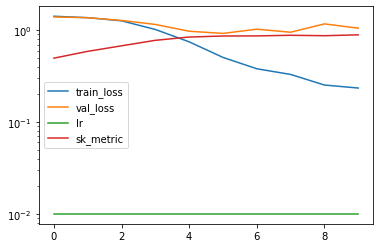

In [9]:
## Example sklearn classification dataset and metrics wrapper with custom model
model_params = {'D_in': 256, 
                'H': 192, 
                'D_out': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': 'X',
                              'targets': 'y',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'make': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 256,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=128, epochs=10, squeeze_y=True)

Files already downloaded and verified
CDataset created...
TVDS created...
Files already downloaded and verified
CDataset created...
TVDS created...
TorchVision model resnet18 loaded...
learning time: 0:00:12.766300
epoch: 0, lr: 0.01
train loss: 2.350050781726837, val loss: 2.061542647500192
sklearn train metric: 0.6246958623241589, sklearn validation metric: 0.7082536102748613
learning time: 0:00:25.006073
epoch: 1, lr: 0.01
train loss: 2.0448885731697084, val loss: 2.02150031059019
sklearn train metric: 0.7135475532780466, sklearn validation metric: 0.763574224305523
learning time: 0:00:37.219640
epoch: 2, lr: 0.01
train loss: 1.9264592418670654, val loss: 1.9110499947301802
sklearn train metric: 0.7598983212672379, sklearn validation metric: 0.7822236028370051
learning time: 0:00:49.435955
epoch: 3, lr: 0.01
train loss: 1.833668773651123, val loss: 1.7923830439967494
sklearn train metric: 0.7853819017471476, sklearn validation metric: 0.808349592160526
learning time: 0:01:01.903289


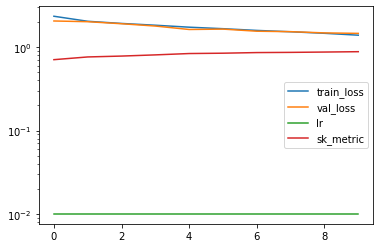

In [10]:
## Example torchvision dataset, transforms and model wrapper
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(224),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(224),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=16, epochs=10)

CDataset created...
TVDS created...
CDataset created...
TVDS created...
CModel loaded...
ResBam model loaded...
learning time: 0:00:26.063456
epoch: 0, lr: 0.005
train loss: 1.9770894975662232, val loss: 1.8603164880506453
sklearn train metric: 0.7430353217070538, sklearn validation metric: 0.7847721910307964
learning time: 0:00:52.340247
epoch: 1, lr: 0.005
train loss: 1.821748423576355, val loss: 1.7782507481113556
sklearn train metric: 0.7934062836435054, sklearn validation metric: 0.8030849546610777
learning time: 0:01:18.263208
epoch: 2, lr: 0.005
train loss: 1.7283291082382202, val loss: 1.703515079713637
sklearn train metric: 0.8181364659611203, sklearn validation metric: 0.8243283061210569
learning time: 0:01:44.379856
epoch: 3, lr: 0.005
train loss: 1.6502257661819457, val loss: 1.6904362824655348
sklearn train metric: 0.8360184905800494, sklearn validation metric: 0.8245105519542891
learning time: 0:02:10.343532
epoch: 4, lr: 0.005
train loss: 1.5918678531646728, val loss: 1.

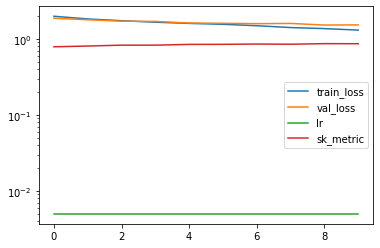

In [11]:
## Example torchvision dataset wrapper with custom model
model_params = {'n_classes': 10,
                'residual': True,
                'in_channels': 3,
                'groups': 4,
                'bam': True,
                'dropout': [.1,.2,.3,.2,.1],
                #'act': None
               }


ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor(),
                                                       transforms.Normalize(.13,.29)]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize(.13,.29)]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.005}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          ResBam, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=32, epochs=10)

CDataset created...
TVDS created...
CDataset created...
TVDS created...
TorchVision model resnext50_32x4d loaded...
learning time: 0:01:03.383569
epoch: 0, lr: 0.01
train loss: 2.742031105041504, val loss: 2.08907651324426
sklearn train metric: 0.579993349589464, sklearn validation metric: 0.6961315761137996
learning time: 0:02:04.102469
epoch: 1, lr: 0.01
train loss: 2.077585282802582, val loss: 2.0735954680750446
sklearn train metric: 0.6959127173751064, sklearn validation metric: 0.7194488562937522
learning time: 0:03:04.853559
epoch: 2, lr: 0.01
train loss: 1.9990341329574586, val loss: 1.9476736976254372
sklearn train metric: 0.7325392623588727, sklearn validation metric: 0.758919840416415
learning time: 0:04:05.730872
epoch: 3, lr: 0.01
train loss: 1.9248782362937926, val loss: 1.9142184718962638
sklearn train metric: 0.7585841874061883, sklearn validation metric: 0.7784187148143584
learning time: 0:05:06.628094
epoch: 4, lr: 0.01
train loss: 1.8662745118141175, val loss: 1.77840

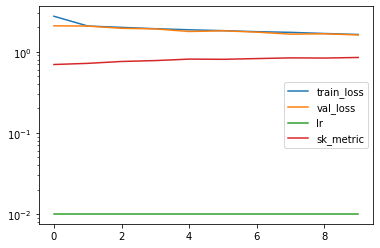

In [2]:
## Example torchvision dataset and model wrapper
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=16, epochs=10)